# CORD-19 Veri Seti ile COVID-19 Bilgi Madenciliği
Bu projede Kaggle'dan alınan CORD-19 veri seti kullanılarak bilimsel makalelerin başlıkları ve özetleri üzerinden metin madenciliği yapılacaktır.
Amaç, araştırmacıların yüksek öncelikli konuları daha kolay bulmasını sağlamaktır.

In [1]:
#Kütüphanelerin yüklenmesi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Veri Setinin Yüklenmesi

In [3]:
df = pd.read_csv('metadata.csv', low_memory=False)
df = df[['title', 'abstract', 'publish_time']].dropna()
df.head()

,title,abstract,publish_time
0,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...,2001-07-04
1,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...,2000-08-15
2,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...,2000-08-25
3,Role of endothelin-1 in lung disease,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22
4,Gene expression in epithelial cells in respons...,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11


# Veri Temizleme

In [4]:
# Küçük harfe çevir, özel karakterleri kaldır
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_abstract'] = df['abstract'].apply(clean_text)


# Anahtar Kelime Analizi (TF-IDF)

In [5]:
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = vectorizer.fit_transform(df['clean_abstract'])

# En yüksek TF-IDF skorlu kelimeler
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.sum().sort_values(ascending=False).head(20)

covid          50708.841016
patients       42033.117498
pandemic       25824.621762
sarscov        25354.832614
health         24711.520887
study          22546.341330
disease        21134.556548
data           18940.216794
infection      18174.779888
results        17622.661997
coronavirus    16648.490138
care           16220.575870
clinical       16137.120492
using          15574.379995
risk           15165.757835
treatment      14580.681512
virus          14544.329006
cases          14138.144851
use            13885.255705
used           13708.438528
dtype: float64

# Word Cloud (Kelime Bulutu)

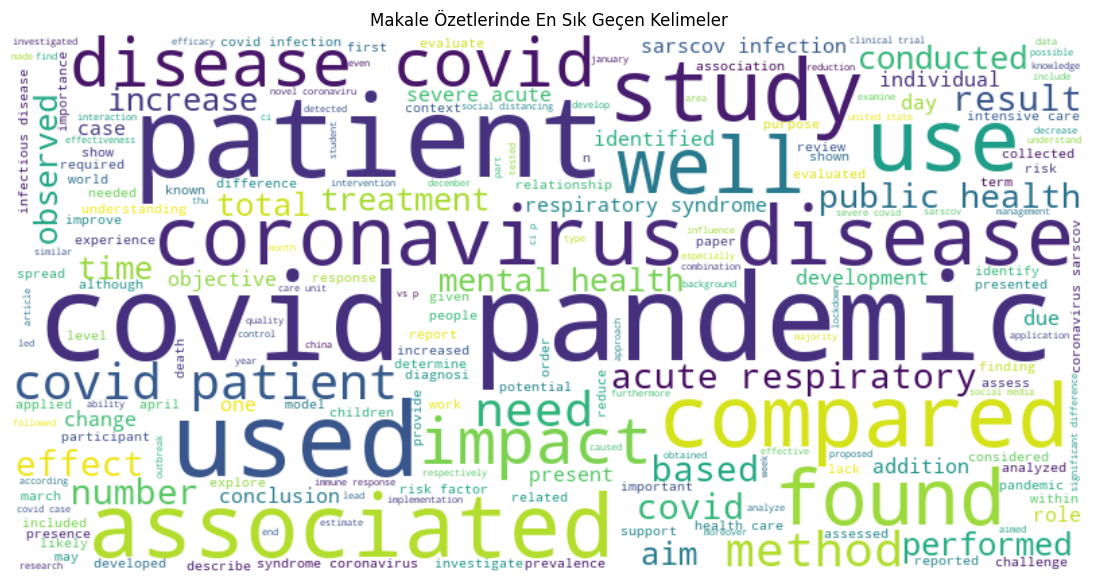

In [8]:
text = " ".join(df['clean_abstract'].values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Makale Özetlerinde En Sık Geçen Kelimeler")
plt.show()


# Kümelendirme ile Konu Gruplama (KMeans + PCA)

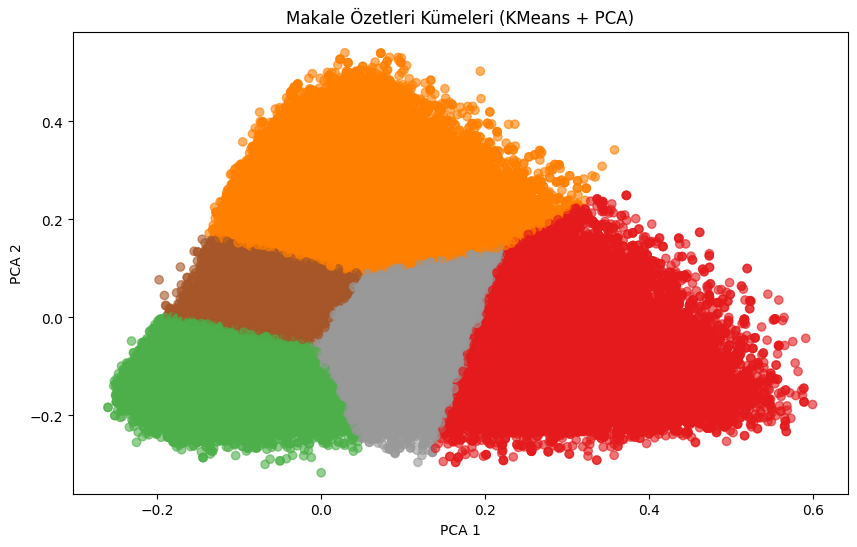

In [9]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X_pca)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='Set1', alpha=0.6)
plt.title("Makale Özetleri Kümeleri (KMeans + PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

# Zaman Analizi

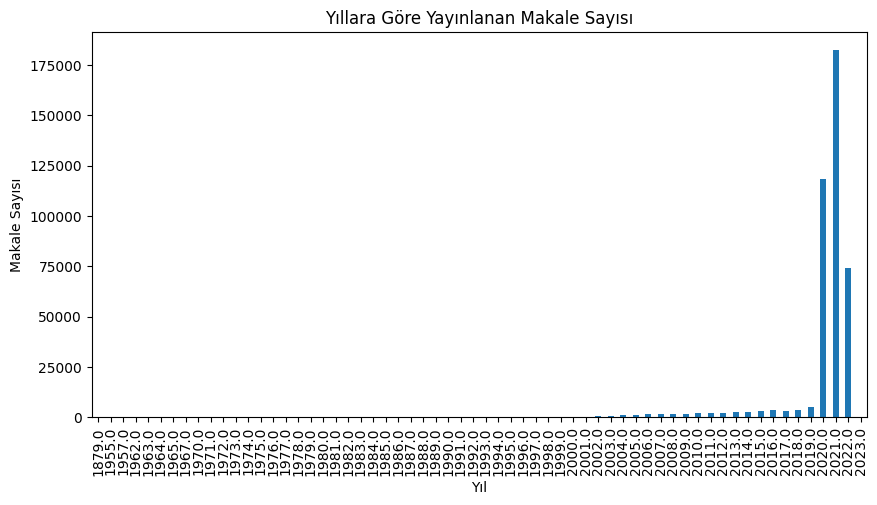

In [13]:
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
df['year'] = df['publish_time'].dt.year

df['year'].value_counts().sort_index().plot(kind='bar', figsize=(10,5))
plt.title("Yıllara Göre Yayınlanan Makale Sayısı")
plt.xlabel("Yıl")
plt.ylabel("Makale Sayısı")
plt.show()


# 💊 COVID-19 için önerilen ilaçlar nelerdir?

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
df = df[['title', 'abstract']]
df = df.dropna(subset=['abstract'])
df['abstract'] = df['abstract'].str.lower()

In [23]:
drug_list = [
    'remdesivir', 'hydroxychloroquine', 'chloroquine', 'azithromycin',
    'lopinavir', 'ritonavir', 'favipiravir', 'dexamethasone',
    'tocilizumab', 'interferon', 'ivermectin', 'molnupiravir',
    'baricitinib', 'fluvoxamine', 'nirmatrelvir', 'paxlovid'
]

In [24]:
def find_drugs(text, drug_list):
    return [drug for drug in drug_list if drug in text]

df['found_drugs'] = df['abstract'].apply(lambda x: find_drugs(x, drug_list))
df_with_drugs = df[df['found_drugs'].map(len) > 0]

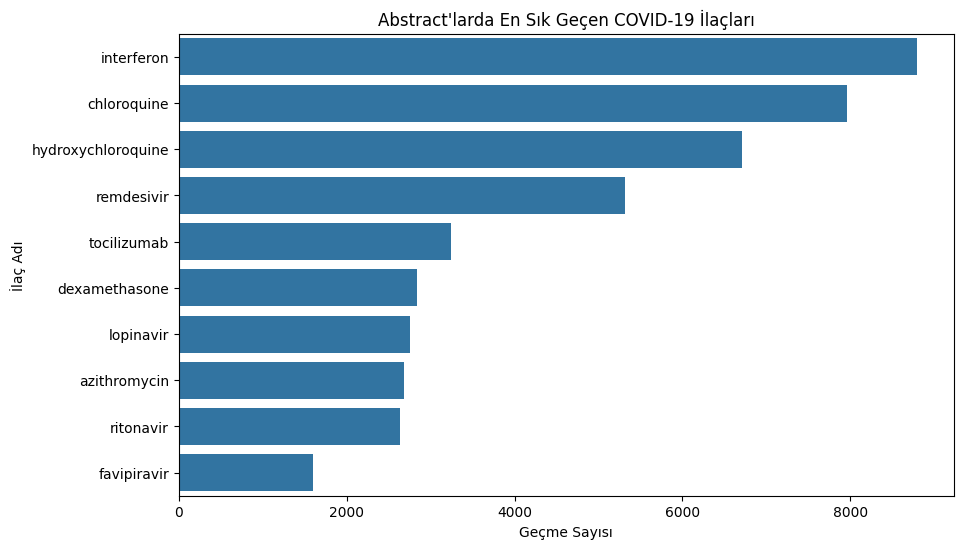

In [25]:
from collections import Counter

drug_counts = Counter()
for drug_list in df_with_drugs['found_drugs']:
    drug_counts.update(drug_list)

top_drugs = dict(drug_counts.most_common(10))

plt.figure(figsize=(10,6))
sns.barplot(x=list(top_drugs.values()), y=list(top_drugs.keys()))
plt.title("Abstract'larda En Sık Geçen COVID-19 İlaçları")
plt.xlabel("Geçme Sayısı")
plt.ylabel("İlaç Adı")
plt.show()